# Bayesian model-based hyperparameter optimization

###### INTRODUCTION
Hyperparameters are fundemental for almost any given model to obtain good performance. However, finding good candidate values for these hyperparameters can be computationally expensive. This is caused by the fact that model training and prediction is required to evaluate a single set of candidate values. Typical approaches for hyperparameter tuning include, in increasing order of [efficiency [1]](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf): manual, grid search and random search.

Recent [results [2]](http://proceedings.mlr.press/v28/bergstra13.pdf) suggest [Bayesian hyperparameter optimization [3]](https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf) of machine learning models is more efficient than manual, grid search, and random search.

In this notebook I will investigate an automated hyperparameter tuning approach using Bayesian optimization. This method falls under the class of Sequential Model-Based Optimization (SMBO). The key concept is to build a surrogate model of the objective function to determine promising candidate values to try as hyperparameters in the true objective function.

By spending a bit more time selecting which input values are promising less calls to the expensive true objective function are needed saving time in the long run. In order to decide which hyperparameters to try, results of past iterations can be used to make an informed guess. Simply put, we introduce logic to suggest good hyperparameter values given the past observed results.

To run the optimization we need the following components:

- Objective function to minimize
- Search space for the hyperparameters
- Algorithm for optimization
- History of results

I will use the package [HyperOpt [4]](https://github.com/hyperopt/hyperopt) which is based on the Tree Parzen Estimator ([TPE [4]](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)) algorithm. Alternative optimization algorithms to build the surrogate model include Gaussian Processes (GPs) and Sequential Model-Based Optimization for General Algorithm Configuration ([SMAC [5]](https://www.cs.ubc.ca/~hutter/papers/10-TR-SMAC.pdf)).

TLDR: We want to find model hyperparameters yielding the best result and we want find them as fast as possible.


In [7]:
# Setup
import numpy as np
import pandas as pd
import ast
import csv
import gc
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('darkgrid'); sns.set_palette('inferno')

import xgboost as xgb
import hyperopt as hyper
import timefold

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from timeit import default_timer as timer
from tqdm import tqdm


## DATA


In [2]:
# Load and prepare dataframe for PO Netherlands
print('[+] Reading & preparing data \n')
df = pd.read_csv('data/products_ordered_bq_sub_features.csv')
df = df.dropna()  # Drop future rows (no actuals)
df['actual'] = df['actual'] - df['blacklist']  # Remove blacklisted orders from target
df.drop('blacklist', axis=1, inplace=True)  # Drop blacklist feature
df.drop('key_id', axis=1, inplace=True)  # Drop key_id feature (we only have NL=1)
# df.info()

# Define data to be used for training
df['date'] = pd.to_datetime(df['date'])
# df = df[df['date'] > '01-01-2016']
# df['date'].describe()

# seasonality_dummy_columns = df.filter(regex=('^seasonality.*dummy.*$')).columns.values
# seasonality_dom_columns = df.filter(regex=('^seasonality\|day_of_month\|$')).columns.values
# holiday_columns = df.filter(regex=('.*holiday.*')).columns.values
# closed_day_columns = df.filter(regex=('.*closed.*')).columns.values
# training_columns = np.array([['date'], ['actual'], seasonality_dummy_columns,
#                              seasonality_dom_columns, holiday_columns, closed_day_columns])
# training_columns = [feature for array in training_columns for feature in array]  # Flatten list into single array
# df = df[training_columns]  # Subset data to defined columns

features = [f for f in df.columns if f not in ['date', 'actual']]  # Define training features
X, y = df[features], df['actual']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)  # Split into train/test


[+] Reading & preparing data 



## CROSS-VALIDATION

In [3]:
# Cross-validation setup using timefold
print('[+] Defining cross-validation setup \n')
min_train_size = 770  # 2 years training
min_test_size = 120  # 4 months of testing
step_size = 70  # 2 month step size between folds
timefolds = timefold.timefold(method='step', min_train_size=min_train_size, min_test_size=min_test_size,
                              step_size=step_size) # Use timefold custom CV to create the folds


[+] Defining cross-validation setup 



## OBJECTIVE FUNCTION
Define a function with the objective to minimize


In [4]:
print('[+] Defining objective function \n')

def objective(params):
    """Objective function to optimize (XGBoost model)"""

    start_time = timer() # Keep track of training time
    global ITERATION  # Keep track of evals
    ITERATION += 1

    fold_loss = [] # Placeholder to store loss of the folds

    # Train XGBoost model using specified CV
    for fold, (train_idx, test_idx) in enumerate(timefolds.split(df)):
        # Create XGBoost train/test dataframes for this fold
        dtrain = xgb.DMatrix(X[features].iloc[train_idx], label=y.iloc[train_idx])
        dtest = xgb.DMatrix(X[features].iloc[test_idx], label=y.iloc[test_idx])

        # Ensure parameters that need to be integers are integers
        for param_name in ['max_depth', 'min_child_weight']:
            params[param_name] = int(params[param_name])

        # watchlist = [(dtrain, 'train'), (dtest, 'eval')]
        booster = xgb.train(params, dtrain)
        fold_predictions = booster.predict(dtest)
        fold_loss.append(np.sqrt(mean_squared_error(y.iloc[test_idx], fold_predictions)))  # Compute rmse of fold
        loss = np.mean(fold_loss)  # Compute average rmse over folds (this is the loss for that evaluation)

    run_time = np.round(timer() - start_time, 4)
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, params, ITERATION, run_time])
    gc.collect()

    return {'loss': loss, 'params': params, 'iteration': ITERATION, 'train_time': run_time, 'status': hyper.STATUS_OK}


[+] Defining objective function 



## SEARCH SPACE
Extra information can be supplied to the search space. For example, if there is already an idea which search space is a proper value for a certain hyperparameter.
In this case this idea can be represented as a distribution, for example a normal distribution with mean 3 would result in more evaluations around the value 3 then the value 5.
A non-informative uniform prior can be used to specify the search range. This is to be interpreted that we have equal believe in any value to be a good one within the upper and lower bound.


100%|██████████| 5000/5000 [00:25<00:00, 197.71it/s]


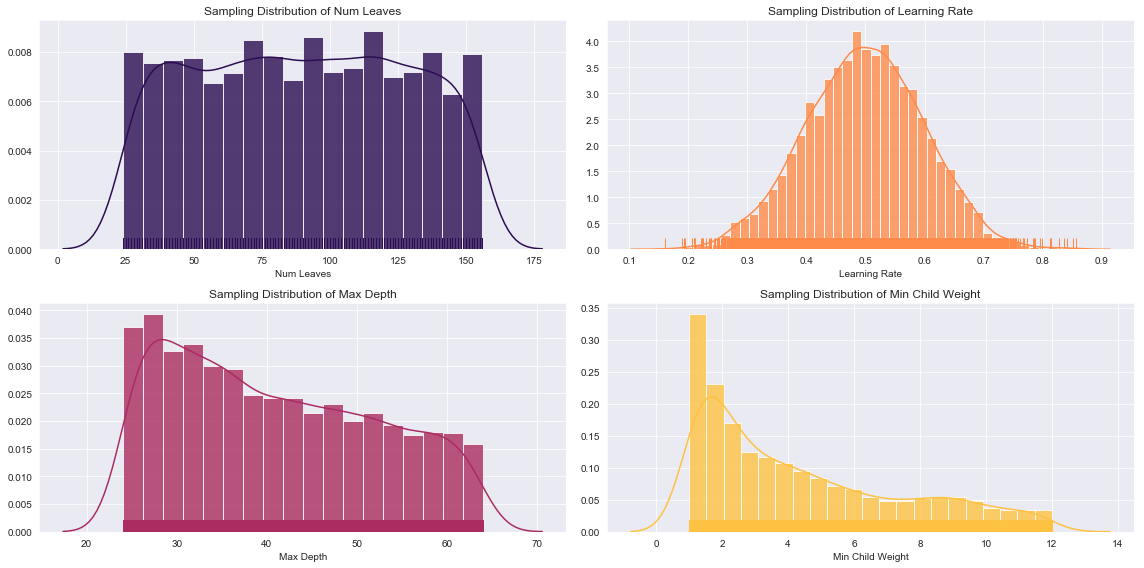

In [5]:
# Define some distributions for hyperparameter search spaces to show example behavior
num_leaves = {'num_leaves': hyper.hp.quniform('num_leaves', low=24, high=156, q=1)}
learning_rate = {'learning_rate': hyper.hp.normal('learning_rate', mu=0.5, sigma=0.1)}
max_depth = {'max_depth': hyper.hp.loguniform('max_depth', low=np.log(24), high=np.log(64))}
min_child_weight = {'min_child_weight': hyper.hp.loguniform('min_child_weight', low=np.log(1), high=np.log(12))}

# Sample x times from the defined search spaces
num_leaves_dist = []
learning_rate_dist = []
max_depth_dist = []
min_child_weight_dist = []
for i in tqdm(range(5000)):
    num_leaves_dist.append(hyper.pyll.stochastic.sample(num_leaves)['num_leaves'])
    learning_rate_dist.append(hyper.pyll.stochastic.sample(learning_rate)['learning_rate'])
    max_depth_dist.append(hyper.pyll.stochastic.sample(max_depth)['max_depth'])
    min_child_weight_dist.append(hyper.pyll.stochastic.sample(min_child_weight)['min_child_weight'])

# Plot distrubtions of the sampling from the search space
fig, axs = plt.subplots(2, 2, figsize=(16, 8))
for hyper, samples, color, axs in zip(['Num Leaves', 'Learning Rate', 'Max Depth', 'Min Child Weight'],
                                      [num_leaves_dist, learning_rate_dist, max_depth_dist, min_child_weight_dist],
                                      ['#2B0D51', '#FF8B4B', '#AB2C60', '#FEC242'], axs.flat):
    sns.distplot(samples, color=color, rug=True, hist_kws=dict(alpha=0.8), ax=axs);
    axs.set(title='Sampling Distribution of {}'.format(hyper), xlabel='{}'.format(hyper));
    plt.tight_layout()


In [8]:
# Define the search space used during optimization
print('[+] Defining hyperparateter search space \n')

search_space = {
    'boosting_type': 'gbdt',
    'num_boost_rounds' : hyper.hp.quniform('num_boost_rounds', 100, 1000, 1),
    'learning_rate': hyper.hp.quniform('learning_rate', 0.005, 1, 0.025),
    'max_depth': hyper.hp.quniform('max_depth', 1, 64, 1),
    'gamma': hyper.hp.quniform('gamma', 0, 1, 0.1),
    'min_child_weight': hyper.hp.quniform('min_child_weight', 1, 10, 1),
    'colsample_bytree': hyper.hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'reg_alpha': hyper.hp.quniform('reg_alpha', 0, 5, 0.1),
    'reg_lambda': hyper.hp.quniform('reg_lambda', 0, 5, 0.1),
    'eval_metric': 'rmse',
    'nthread': 4,
    'silent': 1,
    'verbose': -1}


[+] Defining hyperparateter search space 



## OPTIMIZATION FUNCTION
I use the Tree Parzen Estimator (TPE) algorithm which provides the logic for sequential search of the hyperparameter space


In [9]:
def optimize(search_space, bayes_trials, evals):
    """Define a function to optimize the objective function using TPE"""

    print('[+] Running optimization [{} evaluations] \n'.format(evals))

    result = hyper.fmin(fn=objective, space=search_space, algo=hyper.tpe.suggest, trials=bayes_trials, max_evals=evals,
                        return_argmin=True, show_progressbar=True)


## HISTORY


In [10]:
ITERATION = 0
bayes_trials = hyper.Trials()  # Object where history of search trails are stored
out_file = 'results/bayesian_trials.csv' # File to save results
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)
writer.writerow(['loss', 'params', 'iteration', 'train_time'])  # Write  headers to the file
of_connection.close()


## RUN OPTIMIZATION


In [11]:
optimize(search_space, bayes_trials, evals=100)


[+] Running optimization [100 evaluations] 

100%|██████████| 100/100 [03:12<00:00,  1.93s/it, best loss: 3653.7042134401963]


## RESULTS


In [12]:
# Check results
bayes_trials_results = sorted(bayes_trials.results, key = lambda x: x['loss'])  # Sort the results by loss
print('\n[+] Information of best evaluation: \n')
bayes_trials_results[0]



[+] Information of best evaluation: 



{'loss': 3653.7042134401963,
 'params': {'boosting_type': 'gbdt',
  'colsample_bytree': 0.8500000000000001,
  'eval_metric': 'rmse',
  'gamma': 0.7000000000000001,
  'learning_rate': 0.45,
  'max_depth': 17,
  'min_child_weight': 8,
  'nthread': 4,
  'num_boost_rounds': 494.0,
  'reg_alpha': 0.9,
  'reg_lambda': 0.8,
  'silent': 1,
  'verbose': -1},
 'iteration': 74,
 'train_time': 1.9531000000000001,
 'status': 'ok'}

In [13]:
# Check all trials
bayes_trials_results = pd.read_csv('results/bayesian_trials_2500.csv')  # Read the saved csv of all trials
bayes_trials_results

# Create a new dataframe with parameter dictionary spread out across columns
bayes_trials_results_df = pd.DataFrame(columns = list(ast.literal_eval(bayes_trials_results.loc[0, 'params']).keys()),
                            index = list(range(len(bayes_trials_results))))

for i, params in enumerate(bayes_trials_results['params']): # Add the results with each parameter a different column
    bayes_trials_results_df.loc[i, :] = list(ast.literal_eval(params).values())

bayes_trials_results_df['loss'] = bayes_trials_results['loss']
bayes_trials_results_df['iteration'] = bayes_trials_results['iteration']
bayes_trials_results_df['train_time'] = bayes_trials_results['train_time']
bayes_trials_results_df.head()


,boosting_type,colsample_bytree,eval_metric,gamma,learning_rate,max_depth,min_child_weight,nthread,num_boost_rounds,reg_alpha,reg_lambda,silent,verbose,loss,iteration,train_time
0,gbdt,0.8,rmse,0.8,0.8,22,2,4,892,3.4,4.5,1,-1,4267.734850,1,2.4840
1,gbdt,0.7,rmse,0.5,0.95,3,9,4,863,4.2,1.5,1,-1,3963.577644,2,0.5257
2,gbdt,0.65,rmse,0.9,0.925,61,10,4,265,0.4,4.4,1,-1,4145.818521,3,1.9327
3,gbdt,0.9,rmse,0.4,0.55,52,8,4,829,3.1,1.3,1,-1,3803.657994,4,2.6807
4,gbdt,0.6,rmse,0.2,0.2,10,8,4,771,2.7,0.3,1,-1,4580.737252,5,1.0838


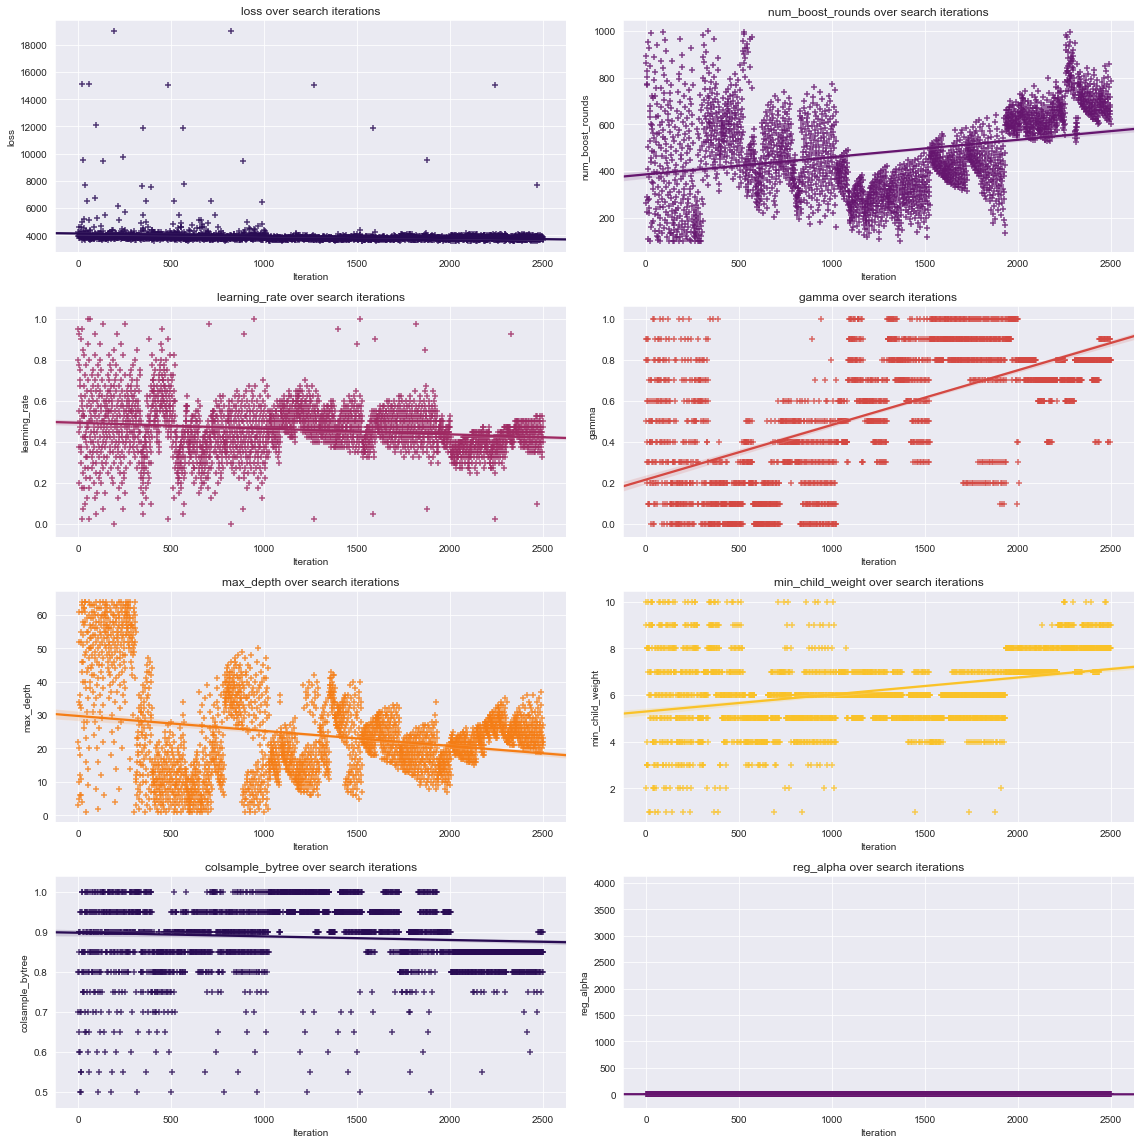

In [14]:
# Plot results across the iterations
fig, axs = plt.subplots(4, 2, figsize=(16, 16))
for hyper, axs in zip(['loss', 'num_boost_rounds', 'learning_rate', 'gamma', 'max_depth',
                           'min_child_weight', 'colsample_bytree', 'reg_alpha', 'reg_lambda'], axs.flat):
    sns.regplot(x='iteration', y=hyper, data=bayes_trials_results_df, ax=axs, marker='+')
    axs.set(xlabel='Iteration', ylabel='{}'.format(hyper), title='{} over search iterations'.format(hyper));
    plt.tight_layout()